<a href="https://colab.research.google.com/github/haopy819/Colab_code/blob/main/ASIS_Data_on_GEE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import API and get credentials

The Earth Engine API is installed by default in Google Colaboratory so requires only importing and authenticating. These steps must be completed for each new Colab session, if you restart your Colab kernel, or if your Colab virtual machine is recycled due to inactivity.

### Import the API

Run the following cell to import the API into your session.

In [ ]:
import ee

### Authenticate and initialize

Run the `ee.Authenticate` function to authenticate your access to Earth Engine servers and `ee.Initialize` to initialize it. Upon running the following cell you'll be asked to grant Earth Engine access to your Google account. Follow the instructions printed to the cell.

In [ ]:
from google.colab import auth

auth.authenticate_user()

In [ ]:
# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=GjoKI4OjSMx5F66ZCvvFoSEXhnxVOyBofAOmraOyWvA&tc=saPZImqLIsasXwJt83kpzaRzs_iF5bTPYRuTfCvYc-E&cc=hIH8K7QwiS99B_yY11yEON1BOkLJnBDSdkm988mNsoU

The authorization workflow will generate a code, which you should paste in the box below.


## Import and Explore Data

some filler about the example dataset

### Importing ASI_D

it might fail if you don't have read access to the data

In [ ]:
ASI_D = ee.ImageCollection("projects/UNFAO/ASIS/ASI_D")

### Filtering ASI_D images by dates


In [ ]:
# start date
startDate = ee.Date.fromYMD(2010,1,1)
# end date
endDate = ee.Date.fromYMD(2015,12,31)
ASI_D = ASI_D.filterDate(startDate, endDate)


# ASI_D = ASI_D.limit(10)

### Filtering ASI_D images by season


In [ ]:

ASI_D = ASI_D.filter(ee.Filter.eq('SEASON_code','S1'))


### Filtering ASI_D images by land type


In [ ]:

ASI_D = ASI_D.filter(ee.Filter.eq('LAND_code','C'))


### Data preprocessing

mask out flag values indicated in the metadata

{'value': 251, 'description': 'off season'}, {'value': 252, 'description': 'no data'}, {'value': 253, 'description': 'no seasonality (or no season2)'}, {'value': 254, 'description': 'no cropland / no grassland'}

In [ ]:
## mask the above values

def mask_flags_values(image):
  mask = image.neq(251).And(image.neq(252)).And(image.neq(253)).And(image.neq(254))
  return image.updateMask(mask)

ASI_D = ASI_D.map(mask_flags_values)

### Visualize using folium

### Interactive map

The [`folium`](https://python-visualization.github.io/folium/)
library can be used to display `ee.Image` objects on an interactive
[Leaflet](https://leafletjs.com/) map. Folium has no default
method for handling tiles from Earth Engine, so one must be defined
and added to the `folium.Map` module before use.

The following cell provides an example of adding a method for handing Earth Engine
tiles and using it to display ASI_D data to a Leaflet map.

In [ ]:
# Import the Folium library.
import folium

# Define a method for displaying Earth Engine image tiles to folium map.
def add_ee_layer(self, ee_image_object, vis_params, name):
  map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
  folium.raster_layers.TileLayer(
    tiles = map_id_dict['tile_fetcher'].url_format,
    attr = 'Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    name = name,
    overlay = True,
    control = True
  ).add_to(self)

# Add EE drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer

# Set visualization parameters. TODO: edit the visualization parameters
vis_params = {
  'min': 0,
  'max': 120,
  'palette': ['006633', 'E5FFCC', '662A00', 'D8D8D8', 'F5F5F5']}

# Create a folium map object.
my_map = folium.Map(location=[20, 0], zoom_start=3)

# Add ASI_D first image to the map object.
my_map.add_ee_layer(ASI_D.first(), vis_params, 'ASI_D')

# Add a layer control panel to the map.
my_map.add_child(folium.LayerControl())

# Display the map.
display(my_map)

## Selecting features for analysis

We will continue this exmaple with GAUL Level 1 boundaries for Angole. **However** note that you can always use your own boundaries by [uploading your shapefile](https://developers.google.com/earth-engine/guides/table_upload) to GEE and use its id below instead of `FAO/GAUL_SIMPLIFIED_500m/2015/level1`


### Importing GAUL level 1


In [ ]:
boundaries = ee.FeatureCollection("FAO/GAUL_SIMPLIFIED_500m/2015/level1");

### Filtering GAUL level 1 for angola boundaries


In [ ]:
boundaries = boundaries.filter(ee.Filter.eq('ADM0_NAME','Angola'))

### Visualize the boundaries with folium

In [ ]:
mapid = boundaries.getMapId()
map = folium.Map(location=[-12.17, 17.53],zoom_start=6)
folium.TileLayer(
    tiles=mapid['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='border',
).add_to(map)
map.add_child(folium.LayerControl())
display(map)

## Zonal statistics

some filler about the zonal stats


### Running zonal stats using map() and reduceRegions()


In [ ]:
# getting nominal scale (native resolution), you can also run the reduction on other scales leading to an approximative results
nominal_scale = ASI_D.first().projection().nominalScale().getInfo()

In [ ]:
# define a function that would reduce a single image
def reduce_single_image(image):
  reduced_feature = image.reduceRegions(**{
      'collection' : boundaries,
      'reducer' : ee.Reducer.mean(),
      'scale' : nominal_scale
  })

  return reduced_feature

  ## for performance reasons, we will augment the image metadata later. this is to make the processing considerably faster
  # return reduced_feature.map(lambda feature: ee.Feature(None,feature.toDictionary()
  #                                                           .set('id',image.id())
  #                                                           .set('time_start',image.get('system:time_start'))
  #                                                           .set('time_end',image.get('system:time_end'))
  #                                                           ))

# mapping the function over the collection
stats = ASI_D.map(reduce_single_image)

#flattening the results
stats = stats.flatten()

### Printing example results

Kindly note that the calculation will actually run when you call `getInfo()` so running the following cell can take a few minutes.

In case of `User memory limit exceeded` error, you can result to one of the following solutions:


1.   Reduce the date range for the analysis
2.   Reduce the number of images for the analysis by applying more filters
3. reduce the number of boundaries by applying more filters on the `boundaries` featureCollection
4. request more quota from GEE



In [ ]:
results = stats.getInfo()

In [ ]:
results_processed = results['features']
# creating a cache dictionary for layer metadata. this is to save requests to GEE
layers_metadata_cache = {}
for result in results_processed:
  image_id = "_".join(result['id'].split('_')[:-1])

  # Checking the cache dict for values
  layer_metadata = layers_metadata_cache.get(image_id,None)

  # in case of Cache miss:
  if not layer_metadata:
    # Make requests to get the values
    layer_metadata = {
        'time_start' : ee.Image(f'projects/UNFAO/ASIS/ASI_D/{image_id}').get('system:time_start').getInfo(),
        'time_end' : ee.Image(f'projects/UNFAO/ASIS/ASI_D/{image_id}').get('system:time_end').getInfo()
    }
    # Update the cache for next iterations
    layers_metadata_cache[image_id] = layer_metadata

  # augment results with image metadata and image_id
  result['properties'].update({'id': image_id,
                              **layer_metadata
                               })

results_processed = [result['properties'] for result in results_processed]

In [ ]:
from pprint import pprint

# printing only the first 3 results
pprint(results_processed[:3])

[{'ADM0_CODE': 8,
  'ADM0_NAME': 'Angola',
  'ADM1_CODE': 398,
  'ADM1_NAME': 'Bengo',
  'DISP_AREA': 'NO',
  'EXP1_YEAR': 3000,
  'STATUS': 'Member State',
  'STR1_YEAR': 1000,
  'Shape_Area': 3.16944541614,
  'Shape_Leng': 10.9383485195,
  'id': 'ASI_D_2010-01_S1_C',
  'mean': 0.5308609539496735,
  'time_end': 1263081600000,
  'time_start': 1262304000000},
 {'ADM0_CODE': 8,
  'ADM0_NAME': 'Angola',
  'ADM1_CODE': 399,
  'ADM1_NAME': 'Benguela',
  'DISP_AREA': 'NO',
  'EXP1_YEAR': 3000,
  'STATUS': 'Member State',
  'STR1_YEAR': 1000,
  'Shape_Area': 3.27654239165,
  'Shape_Leng': 9.74936842214,
  'id': 'ASI_D_2010-01_S1_C',
  'mean': 0.7432238280836504,
  'time_end': 1263081600000,
  'time_start': 1262304000000},
 {'ADM0_CODE': 8,
  'ADM0_NAME': 'Angola',
  'ADM1_CODE': 400,
  'ADM1_NAME': 'Bie',
  'DISP_AREA': 'NO',
  'EXP1_YEAR': 3000,
  'STATUS': 'Member State',
  'STR1_YEAR': 1000,
  'Shape_Area': 5.99544239936,
  'Shape_Leng': 15.4703144259,
  'id': 'ASI_D_2010-01_S1_C',
  'mean

## Exploring results with pandas

### Import pandas and load the data into a dataframe


In [ ]:
import pandas as pd


dataframe = pd.DataFrame.from_records(results_processed)

# printing the first 10 rows in the dataframe
dataframe.head(10)

,ADM0_CODE,ADM0_NAME,ADM1_CODE,ADM1_NAME,DISP_AREA,EXP1_YEAR,STATUS,STR1_YEAR,Shape_Area,Shape_Leng,mean,id,time_start,time_end
0,8,Angola,398,Bengo,NO,3000,Member State,1000,3.169445,10.938349,0.530861,ASI_D_2010-01_S1_C,1262304000000,1263081600000
1,8,Angola,399,Benguela,NO,3000,Member State,1000,3.276542,9.749368,0.743224,ASI_D_2010-01_S1_C,1262304000000,1263081600000
2,8,Angola,400,Bie,NO,3000,Member State,1000,5.995442,15.470314,0.224914,ASI_D_2010-01_S1_C,1262304000000,1263081600000
3,8,Angola,401,Cabinda,NO,3000,Member State,1000,0.578679,5.224367,7.689093,ASI_D_2010-01_S1_C,1262304000000,1263081600000
4,8,Angola,402,Cuando Cubango,NO,3000,Member State,1000,16.837750,21.852844,0.002081,ASI_D_2010-01_S1_C,1262304000000,1263081600000
5,8,Angola,403,Cuanza Sul,NO,3000,Member State,1000,4.562596,11.320882,0.004028,ASI_D_2010-01_S1_C,1262304000000,1263081600000
6,8,Angola,404,Cunene,NO,3000,Member State,1000,6.534280,12.103746,0.000000,ASI_D_2010-01_S1_C,1262304000000,1263081600000
7,8,Angola,405,Huambo,NO,3000,Member State,1000,2.760231,7.826323,0.000220,ASI_D_2010-01_S1_C,1262304000000,1263081600000
8,8,Angola,406,Huila,NO,3000,Member State,1000,6.607929,13.356435,0.621148,ASI_D_2010-01_S1_C,1262304000000,1263081600000
9,8,Angola,407,Kuanza Norte,NO,3000,Member State,1000,1.582035,7.209874,0.000871,ASI_D_2010-01_S1_C,1262304000000,1263081600000


### Create new columns for season, readable date, etc

You can comment out, or add more sections as necessary

In [ ]:
# extrapolating the season column from the id
dataframe['season'] = dataframe['id'].apply(lambda id: 'S1' if 'S1' in id else 'S2')

In [ ]:
# extrapolating the land type column from the id
dataframe['land'] = dataframe['id'].apply(lambda id: 'cropland' if id.endswith('C') else 'grassland')

In [ ]:
# converting time_start and time_end to a normal YYYY-MM-DD date format
dataframe['time_start_formatted'] = pd.to_datetime(dataframe['time_start'],unit='ms')
dataframe['time_end_formatted'] = pd.to_datetime(dataframe['time_end'],unit='ms')

In [ ]:
# extrapolating dekad number, and year from the id
import re
pattern = 'ASI_D_(?P<Year>[0-9]{4})-(?P<Dekad>[0-9]{2})_S(?P<Season>[12])_(?P<Land>[A-Z]{1})'
match = re.match(pattern, 'ASI_D_2010-01_S1_C')
dataframe['dekad_no'] = dataframe['id'].apply(lambda id: int(re.match(pattern, id).groupdict().get('Dekad',None)))
dataframe['year'] = dataframe['id'].apply(lambda id: int(re.match(pattern, id).groupdict().get('Year',None)))

In [ ]:
# Now let's look at the dataframe after the processing and cleaning
dataframe.head(10)

,ADM0_CODE,ADM0_NAME,ADM1_CODE,ADM1_NAME,DISP_AREA,EXP1_YEAR,STATUS,STR1_YEAR,Shape_Area,Shape_Leng,mean,id,time_start,time_end,season,land,time_start_formatted,time_end_formatted,dekad_no,year
0,8,Angola,398,Bengo,NO,3000,Member State,1000,3.169445,10.938349,0.530861,ASI_D_2010-01_S1_C,1262304000000,1263081600000,S1,cropland,2010-01-01,2010-01-10,1,2010
1,8,Angola,399,Benguela,NO,3000,Member State,1000,3.276542,9.749368,0.743224,ASI_D_2010-01_S1_C,1262304000000,1263081600000,S1,cropland,2010-01-01,2010-01-10,1,2010
2,8,Angola,400,Bie,NO,3000,Member State,1000,5.995442,15.470314,0.224914,ASI_D_2010-01_S1_C,1262304000000,1263081600000,S1,cropland,2010-01-01,2010-01-10,1,2010
3,8,Angola,401,Cabinda,NO,3000,Member State,1000,0.578679,5.224367,7.689093,ASI_D_2010-01_S1_C,1262304000000,1263081600000,S1,cropland,2010-01-01,2010-01-10,1,2010
4,8,Angola,402,Cuando Cubango,NO,3000,Member State,1000,16.837750,21.852844,0.002081,ASI_D_2010-01_S1_C,1262304000000,1263081600000,S1,cropland,2010-01-01,2010-01-10,1,2010
5,8,Angola,403,Cuanza Sul,NO,3000,Member State,1000,4.562596,11.320882,0.004028,ASI_D_2010-01_S1_C,1262304000000,1263081600000,S1,cropland,2010-01-01,2010-01-10,1,2010
6,8,Angola,404,Cunene,NO,3000,Member State,1000,6.534280,12.103746,0.000000,ASI_D_2010-01_S1_C,1262304000000,1263081600000,S1,cropland,2010-01-01,2010-01-10,1,2010
7,8,Angola,405,Huambo,NO,3000,Member State,1000,2.760231,7.826323,0.000220,ASI_D_2010-01_S1_C,1262304000000,1263081600000,S1,cropland,2010-01-01,2010-01-10,1,2010
8,8,Angola,406,Huila,NO,3000,Member State,1000,6.607929,13.356435,0.621148,ASI_D_2010-01_S1_C,1262304000000,1263081600000,S1,cropland,2010-01-01,2010-01-10,1,2010
9,8,Angola,407,Kuanza Norte,NO,3000,Member State,1000,1.582035,7.209874,0.000871,ASI_D_2010-01_S1_C,1262304000000,1263081600000,S1,cropland,2010-01-01,2010-01-10,1,2010


### Plot an example time series graph for cropland in S1 on 1 region of Angola

Let's say we want to plot a time series for Season 1 in the `Bengo` region

In [ ]:
# Filter the dataframe
dataframe = dataframe[(dataframe.season == 'S1')
                     &(dataframe.ADM1_NAME == 'Bengo')
                     &(dataframe.land == 'cropland')]

In [ ]:
# Now let's see a sample of the filtered results
dataframe.head()

,ADM0_CODE,ADM0_NAME,ADM1_CODE,ADM1_NAME,DISP_AREA,EXP1_YEAR,STATUS,STR1_YEAR,Shape_Area,Shape_Leng,mean,id,time_start,time_end,season,land,time_start_formatted,time_end_formatted,dekad_no,year
0,8,Angola,398,Bengo,NO,3000,Member State,1000,3.169445,10.938349,0.530861,ASI_D_2010-01_S1_C,1262304000000,1263081600000,S1,cropland,2010-01-01,2010-01-10,1,2010
18,8,Angola,398,Bengo,NO,3000,Member State,1000,3.169445,10.938349,0.709052,ASI_D_2010-02_S1_C,1263168000000,1263945600000,S1,cropland,2010-01-11,2010-01-20,2,2010
36,8,Angola,398,Bengo,NO,3000,Member State,1000,3.169445,10.938349,0.528388,ASI_D_2010-03_S1_C,1264032000000,1264896000000,S1,cropland,2010-01-21,2010-01-31,3,2010
54,8,Angola,398,Bengo,NO,3000,Member State,1000,3.169445,10.938349,0.516682,ASI_D_2010-04_S1_C,1264982400000,1265760000000,S1,cropland,2010-02-01,2010-02-10,4,2010
72,8,Angola,398,Bengo,NO,3000,Member State,1000,3.169445,10.938349,0.610915,ASI_D_2010-05_S1_C,1265846400000,1266624000000,S1,cropland,2010-02-11,2010-02-20,5,2010


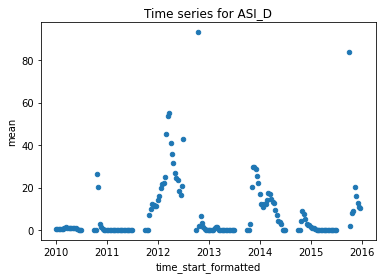

In [ ]:
dataframe.plot(y='mean',x='time_start_formatted',kind='scatter', title = 'Time series for ASI_D')

### Compare Dekad 1 across the years


In [ ]:
# Filter the dataframe
dataframe = dataframe[(dataframe.ADM1_NAME == 'Bengo')
                     &(dataframe.land == 'cropland')
                     &(dataframe.dekad_no == 1)]

In [ ]:
# Now let's see a sample of the filtered results
dataframe.head()

,ADM0_CODE,ADM0_NAME,ADM1_CODE,ADM1_NAME,DISP_AREA,EXP1_YEAR,STATUS,STR1_YEAR,Shape_Area,Shape_Leng,mean,id,time_start,time_end,season,land,time_start_formatted,time_end_formatted,dekad_no,year
0,8,Angola,398,Bengo,NO,3000,Member State,1000,3.169445,10.938349,0.530861,ASI_D_2010-01_S1_C,1262304000000,1263081600000,S1,cropland,2010-01-01,2010-01-10,1,2010
648,8,Angola,398,Bengo,NO,3000,Member State,1000,3.169445,10.938349,0.000000,ASI_D_2011-01_S1_C,1293840000000,1294617600000,S1,cropland,2011-01-01,2011-01-10,1,2011
1296,8,Angola,398,Bengo,NO,3000,Member State,1000,3.169445,10.938349,14.096175,ASI_D_2012-01_S1_C,1325376000000,1326153600000,S1,cropland,2012-01-01,2012-01-10,1,2012
1944,8,Angola,398,Bengo,NO,3000,Member State,1000,3.169445,10.938349,0.000000,ASI_D_2013-01_S1_C,1356998400000,1357776000000,S1,cropland,2013-01-01,2013-01-10,1,2013
2592,8,Angola,398,Bengo,NO,3000,Member State,1000,3.169445,10.938349,16.764159,ASI_D_2014-01_S1_C,1388534400000,1389312000000,S1,cropland,2014-01-01,2014-01-10,1,2014


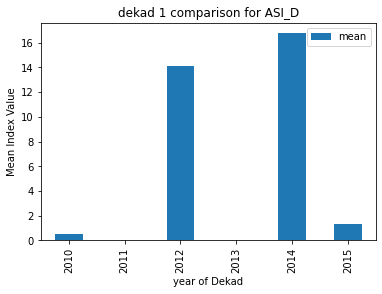

In [ ]:
dataframe.plot(y='mean',x='year',ylabel = 'Mean Index Value', xlabel = 'year of Dekad', kind='bar', title = 'dekad 1 comparison for ASI_D')

### Save the results to CSV


In [ ]:
dataframe.to_csv("results.csv")

## Footer

```
Author: Mohamed Megahed - mohamed.megahed@fao.org.
Further inquiry please contact author or FAO GIEWS at giews1@fao.org
```

